<a href="https://colab.research.google.com/github/gabiskli/adventure-works-sales-prediction/blob/main/adw_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Prediction Analysis

This is a primary analysis done for the Sales Demand director in Adventure Works in order to evaluate different methods of prediciton of sales.

The demand prediction in the department today, is done with a moving average of the last 3 months. And our main objective here is to test different methods and evaluate their performance. Showing how we can improve and help give more information to the business team.

For this we will implement prediction models, that will be discussed further into the analysis, and compare it to the moving average method. Besides this, we will also choose some metrics to evaluate the performance of our models. This analysis will perform a prevision for the next 3 months of sales.

Besides this implementation there are a few questions we aim to answer with this study as well:
- How a regression model would perform against the models applied earlier?
- Considering that we have distribution centers in every province in the US and in every country in the rest of the world. Which group of centers had a greater improve in sales given the predictions?
- A new glove worldwide supplier needs to know how many zippers they will need in the next 3 months to make their gloves. Considering that for each glove they need 2 zippers.

## Data

The data needed is provided from the data warehouse modeling of Adventure Works.

It is provided in an aggregated table called `agg_sales_prediction`. That contains data on product unit sales, per month, store and country.

This notebook is connected to the Data Warehouse and is getting all data from the table above.

There is also a chunk of code to load the data trough a .csv file if wanted. This way if you are not connected to the warehouse, then you can download the file and upload it.

## Steps

The analysis will be done in a few steps that are listed below and will be explained better along the analysis.

- EDA and Data Preparation: Before starting to do the analysis we will explore the data in order to understand it better and to make sure it is complete, consistent and ready for the modeling.

- Hierarchical Time Series Analysis: Here we will apply some techniques of machine learning to predict sales in the next 3 months using different models. We will evaluate these models using some specific metrics and comparing it to the moving average done by ADW workers.

- Business Answers: After deciding which is the best model we will use it to answer our business questions. We will also apply a regression model and compare it to the best model chose from the step above.

# 1. Imports e Configurações Iniciais

## 1.1 External Libraries Installation

In [3]:
!pip install statsforecast --quiet
!pip install hierarchicalforecast --quiet
!pip install skforecast --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


## 1.2 Imports

In [299]:
import pandas as pd
import numpy as np
import statsforecast
import seaborn as sns
import re
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

from utilsforecast.preprocessing import fill_gaps
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, SeasonalNaive, HoltWinters, ADIDA, WindowAverage

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, TopDownSparse
from hierarchicalforecast.evaluation import HierarchicalEvaluation

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

from google.colab import auth
from google.cloud import bigquery


## 1.3 Database Connection and Data Retriving


In [5]:
#Authorizations

auth.authenticate_user()
print('Authenticated')


Authenticated


In [6]:
#Enter Google Cloud/BigQuery Project ID
project_id = 'adventure-works-432501'

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [7]:
QUERY = """
  SELECT *
  FROM
    `adventure-works-432501.prd.agg_sales_prediction`
  """

In [8]:
#Run the query and write result to a pandas data frame
query_results = bq_client.query(QUERY)

df = query_results.to_dataframe()

### 1.3.1 Alternative Data Loading

Use the code chunk below to load the dataset with a .csv file named "agg_sales_prediction.csv"

To run it, exclude the hashtag at the begining of the code. Remeber that you should not run the code from the 1.3 section if you are doing this step.

Dataset will be available in the [GitHub](https://github.com/gabiskli/adventure-works-sales-prediction) of this project.

In [ ]:
#df = pd.read_csv('agg_sales_prediction.csv')

## 1.4 Other Settings

In [300]:
#Adjusting pandas to show every column
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#Filtering warning messages
warnings.filterwarnings('ignore')

##1.5 Global Variables

## 1.6 Auxiliary Functions

In [477]:
def preparing_agregation(df, filter, metric=None):

  df = df.copy()
  dfg = None
  if metric is None:
    dfg = df.groupby(['date'])['sales'].sum().reset_index()
  else:
    dfg = df.groupby([metric,'date'])['sales'].sum().reset_index()
    dfg = dfg[dfg[metric].isin(filter)].drop(columns=metric)
  dfg = dfg.resample('MS', on ='date').sum()
  dfg = dfg.reset_index().rename(columns = {0:'sales'})

  return dfg

In [478]:
def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition:DecomposeResult):

  plt.figure(figsize=(12,8))
  plt.subplot(4,1,1)
  plt.plot(data['sales'], label = 'Original')
  plt.legend(loc='upper left')


  plt.subplot(4,1,2)
  plt.plot(seasonal_decomposition.trend, label = 'Trend')
  plt.legend(loc='upper left')

  plt.subplot(4,1,3)
  plt.plot(seasonal_decomposition.seasonal, label = 'Seasonal')
  plt.legend(loc='upper left')

  plt.subplot(4,1,4)
  plt.plot(seasonal_decomposition.resid, label = 'Residual')
  plt.legend(loc='upper left')

  plt.tight_layout()

  return plt.show()

In [333]:
def rmse(y, y_hat):
  y = np.array(y).flatten()
  y_hat = np.array(y_hat).flatten()
  return np.sqrt(np.mean((y-y_hat)**2))

def wape(y, y_hat):
  y = np.array(y).flatten()
  y_hat = np.array(y_hat).flatten()
  wape = (np.abs(y-y_hat).sum()) / y.sum()
  return wape

In [472]:
def liner_reg_prediction(products, lag ,step):
  predictions_list = []  # Collect predictions for each item

  for item in range(0,len(products.index.unique())):

    df = products[products.index == products.index.unique()[item]]
    df_train = df.iloc[:-step]
    df_test = df.iloc[-step:]

    df_train = df_train.reset_index().drop(columns='unique_id').set_index('ds')
    df_test = df_test.reset_index().drop(columns='unique_id').set_index('ds')

    train_ = df_train.copy().squeeze()

    forecaster = ForecasterAutoreg(regressor=LinearRegression(),lags=lag)
    forecaster.fit(y=train_)

    predictions = forecaster.predict(steps=step)
    predictions = predictions.to_frame()
    predictions.index = ['2014-03-01','2014-04-01','2014-05-01']
    predictions = predictions.reset_index().rename(columns = {'index':'ds'})

    # Store predictions for this item with its unique ID
    predictions['unique_id'] = products.index.unique()[item]
    predictions_list.append(predictions)

  # Concatenate predictions for all items
  all_predictions = pd.concat(predictions_list)
  all_predictions = all_predictions.set_index('unique_id')  # Set unique ID as index
  all_predictions['ds'] = pd.to_datetime(all_predictions['ds'])

  return all_predictions

In [474]:
def chunks(lst, n):
  piece = [lst[i:i + n] for i in range(0, len(lst), n)]
  return piece

# 2. Data Preparation

As stated before, our goal with this first step is to get to know our data better. And make sure it is ready for our modeling phase.

Note that some preparation done here will only be used in the Regression Step, and other will be done for all steps.

Some of the exploration we will do here includes:
- Evaluating seasonality and trend of our target variable.
- Look for and deal with nulls and outliers.
- Do some feature engineering for Regression Models.


## 2.1 Checking the data

In [9]:
df_sales = df.copy()
#View top few rows of result
df_sales.head()

,date_month,country,store,product,units_sold
0,2014-02-01,Germany,Primary Cycle Shop,"ML Road Frame-W - Yellow, 44",1
1,2014-02-01,Germany,Primary Cycle Shop,"Sport-100 Helmet, Blue",2
2,2014-02-01,Germany,Primary Cycle Shop,"Men's Bib-Shorts, M",2
3,2014-04-01,Germany,Bicycle Warehouse Inc.,"Full-Finger Gloves, S",1
4,2014-04-01,Germany,Bicycle Warehouse Inc.,"Full-Finger Gloves, L",5


### 2.1.1 Data Dictionary

| Column Name | Description|
|-----|-----|
| date_month| Month and Year of the purchase |
| country| States the name of the country in which the sale occured|
| store| Name of the store that purchased for ADW. One country can have multiple stores|
| product| Product name|
| units_sold | Count of the units sold for each category.|


In [13]:
# Evaluating the number of columns and rows
df_sales.shape

(60876, 5)

## 2.2 Renaming Columns

Changing a couple columns name to a easier to use name and that will keep their meaning.
I'll change `date_month` to `date` and `units_sold` to `sales`.

In [10]:
df_sales = df_sales.rename(columns = {
    'date_month': 'date',
    'units_sold' : 'sales'
})

In [ ]:
df_sales.head(2)

,date,country,store,product,sales
0,2014-02-01,Germany,Primary Cycle Shop,"ML Road Frame-W - Yellow, 44",1
1,2014-02-01,Germany,Primary Cycle Shop,"Sport-100 Helmet, Blue",2


## 2.3 Checking Data Types

Here we are going to look for data types that was not expected and change them accordingly.

In [15]:
#Evaluating data types and if there is the need to change them
df_sales.dtypes

,0
date,dbdate
country,object
store,object
product,object
sales,Int64


All data types are correct. The sales column data type is int, and that is expected since we are working with units sold and not with monetary amount.

In [11]:
df_sales['date'] = pd.to_datetime(df_sales['date'])

In [17]:
df_sales['date'].dtypes

dtype('<M8[ns]')

## 2.4 Missing Values

Checking to see if there is any missing values and then evaluate how to fill them, is possible.

In [18]:
df_sales.isna().sum()/df_sales.shape[0]*100

,0
date,0.0
country,0.0
store,0.0
product,0.0
sales,0.0


Since the data was previously modelled using dbt, is not a surprise that it does not contains any nulls. It could happen but in this case we don't have them.

But something that cought our attention was that there are some months with no data, this indicates that we didn't have any sale for Stores in this months. This will be filled later when hierarchies are set.

# 3. Statistical Analysis

Here we aim to describe our dataset using basic statistic methos as well as some visualizations.

##3.1 Selecting Variable Types

Since we have both numerical and categorical data, I will divide the dataset into those groups to study them in a separate way.

In [19]:
#Selecting only numerical types
numeric_col = df_sales.select_dtypes(include= ['int64'])

#Selecting only categorical types
categ_col = df_sales.select_dtypes(exclude=['int64', 'M8[ns]'])

In [20]:
numeric_col.head()

,sales
0,1
1,2
2,2
3,1
4,5


In [21]:
categ_col.head()

,country,store,product
0,Germany,Primary Cycle Shop,"ML Road Frame-W - Yellow, 44"
1,Germany,Primary Cycle Shop,"Sport-100 Helmet, Blue"
2,Germany,Primary Cycle Shop,"Men's Bib-Shorts, M"
3,Germany,Bicycle Warehouse Inc.,"Full-Finger Gloves, S"
4,Germany,Bicycle Warehouse Inc.,"Full-Finger Gloves, L"


## 3.2 Numerical Variable

As a numerical category we only have the column Sales, which is our target variable, the one we want to predict.

Let's check its behaviour with statistics.

In [22]:
numeric_col.describe(percentiles=[0.25,0.5,0.75,0.90,0.99]).T

,count,mean,std,min,25%,50%,75%,90%,99%,max
sales,60876.0,3.523819,3.035019,1.0,2.0,3.0,4.0,7.0,15.0,44.0


<Axes: xlabel='sales'>

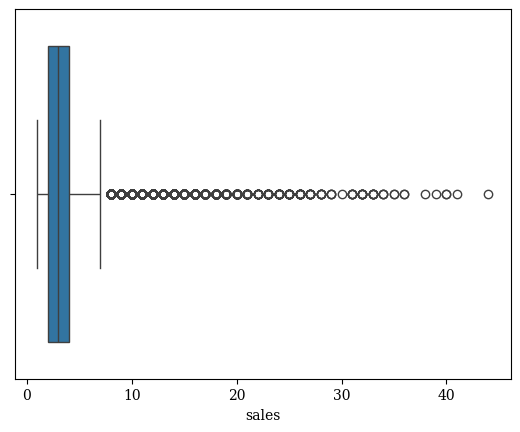

In [23]:
sns.boxplot(
    x=numeric_col.sales
)

Looking at these values, we notice that 99% of our data is ranged from 1 to 15 units sold. And that the maximum of units sold is 44. This gives us a great amount of outliers, as shown in the boxplot.

Although this is a great amount of outliers, we are studying monthly grouped sales and to Stores that resell ADW products. So buying a great amount of unit would not be considered that odd in this case.

That is why these outliers will be kept. It would also be a good idea here to evaluate daily sales or even talk to a bussiness stakeholder to evaluate if these numbers make sense to them.

## 3.3 Categorical Variables
Here we are going to analyze value counts of each category and try to get some insights on how categories are different from each other.

In [24]:
categ_col.head()

,country,store,product
0,Germany,Primary Cycle Shop,"ML Road Frame-W - Yellow, 44"
1,Germany,Primary Cycle Shop,"Sport-100 Helmet, Blue"
2,Germany,Primary Cycle Shop,"Men's Bib-Shorts, M"
3,Germany,Bicycle Warehouse Inc.,"Full-Finger Gloves, S"
4,Germany,Bicycle Warehouse Inc.,"Full-Finger Gloves, L"


### 3.3.1 Country

In [25]:
# Studying Country Category

columns = ['country', 'sales']

dfg = (
    df_sales[columns]
    .groupby('country')['sales']
    .sum()
    .reset_index()
)

In [26]:
dfg

,country,sales
0,Australia,4948
1,Canada,41761
2,France,14348
3,Germany,7518
4,United Kingdom,13193
5,United States,132748


<Axes: xlabel='country', ylabel='sales'>

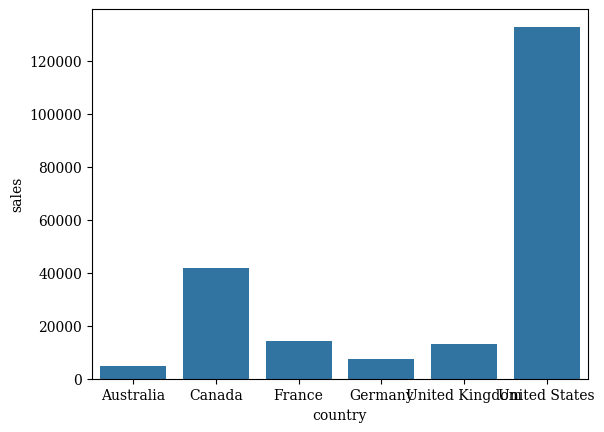

In [27]:
sns.barplot(data= dfg, x='country', y='sales')

In [28]:
df_sales.groupby('country')['sales'].describe(percentiles = [0.25,0.5,0.75,0.9,0.99]).T

country,Australia,Canada,France,Germany,United Kingdom,United States
count,1713.0,11444.0,3530.0,1884.0,3520.0,38785.0
mean,2.8885,3.649161,4.064589,3.990446,3.748011,3.422663
std,2.528541,3.086908,3.299419,3.637726,3.139256,2.960185
min,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,2.0,2.0,2.0,2.0,2.0
50%,2.0,3.0,3.0,3.0,3.0,3.0
75%,4.0,5.0,5.0,5.0,5.0,4.0
90%,6.0,7.0,8.0,9.0,7.0,7.0
99%,12.0,15.0,16.0,18.0,16.0,15.0
max,22.0,32.0,28.0,36.0,27.0,44.0


Country that sold the most units was the US, followed by Canda. Since we have fewer sales in other countries, we can also expected more null.

Meaning that, since we have monthly sales, we should more months with now sales for these countries compared to the US for example. We will study this later.

We also used `describe()`to analyze distribution per country. Again we have some outliers, and the same logic applied for the sales columns will be applied here.

### 3.3.2 Products

In [29]:
columns = ['product', 'sales']

dfg = (
    df_sales[columns]
    .groupby('product')['sales']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

In [30]:
dfg

,product,sales
0,"Long-Sleeve Logo Jersey, L",6140
1,AWC Logo Cap,6121
2,"Sport-100 Helmet, Blue",4618
3,"Sport-100 Helmet, Black",4447
4,"Classic Vest, S",4079
...,...,...
245,"Classic Vest, L",12
246,LL Road Seat/Saddle,10
247,"LL Mountain Frame - Black, 40",8
248,"ML Mountain Frame-W - Silver, 38",7


We have 250 different products in the data frame, and units sold goes from 4 to over 6,000 over the whole period of study.
Is important to note that there are products that are essentially the same but have few differences, such as size or color.

### 3.3.3 Stores

Stores here represent a customer that will resell ADW products. Onw country can have multiple Stores and a Store buys multiple products.

In [31]:
columns = ['store', 'sales']

dfg = (
    df_sales[columns]
    .groupby('store')['sales']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

In [32]:
dfg

,store,sales
0,Vigorous Exercise Company,2737
1,Eastside Department Store,2554
2,Top Sports Supply,2350
3,Registered Cycle Store,2313
4,Metropolitan Equipment,2129
...,...,...
628,Chain and Chain Tool Distributions,1
629,Retail Discount Store,1
630,Tubeless Tire Company,1
631,Gear-Shift Bikes Limited,1


# 4. Seasonality and Trend Analysis

In this section we are going to evaluate different aggregation of the data and study its seasonality and trend components.

This will show us how different levels of hierarchy are over time. And helps us understand which models to use.

In [12]:
data = df_sales.copy()

In [13]:
data = data.sort_values('date')

In [14]:
data.head()

,date,country,store,product,sales
58836,2011-05-01,United States,Great Bikes,"Sport-100 Helmet, Blue",2
58905,2011-05-01,United States,Bike Rims Company,"Road-650 Red, 60",2
58906,2011-05-01,United States,Curbside Universe,"Road-650 Black, 58",2
58907,2011-05-01,United States,Curbside Universe,"Road-650 Black, 44",1
58908,2011-05-01,United States,Fitness Toy Store,"Road-450 Red, 52",3


## 4.1 Total Monthly Sales

In [479]:
dfg = preparing_agregation(df=data, filter = [])

In [480]:
dfg.shape

(37, 2)

<Axes: xlabel='date', ylabel='sales'>

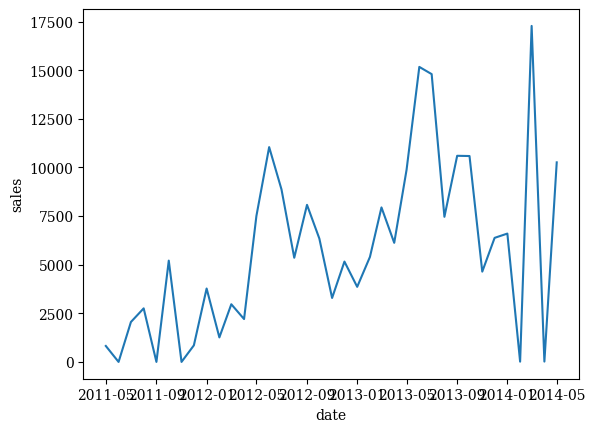

In [38]:
sns.lineplot(x=dfg.date, y=dfg.sales)

In [39]:
result = seasonal_decompose(dfg['sales'], model = 'adictive', period = 12)

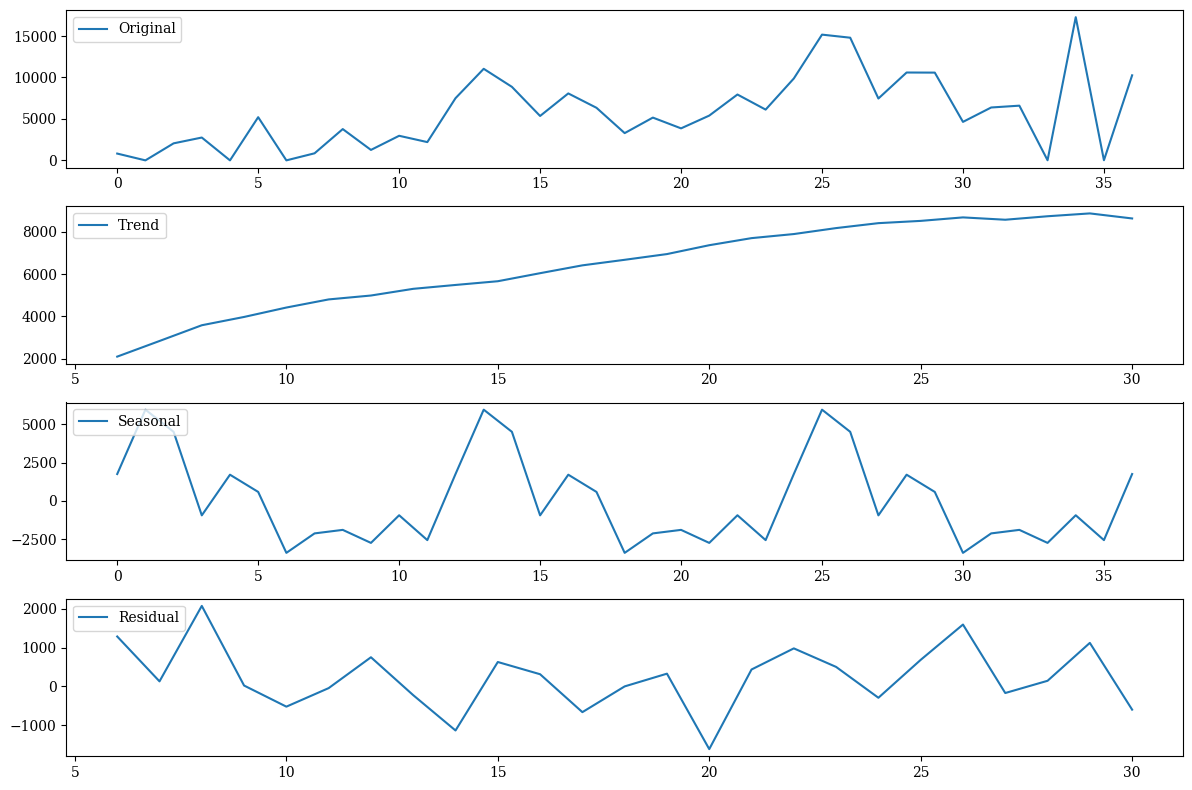

In [40]:
seasonal_decomposition_plots(data=dfg, seasonal_decomposition=result)

We can see that for the sales aggregation per month there is a tendency to increase sales over the year. Although the series has a drop at the end.

When we split the series and study trend and seasonality separated. We can se that the trend is upward and in the last 5 months or so it becames more flattened.

As for seasonality we can see a 12-month seasonality in the data. With sales increasing in the first six months and then going down.

Let's also look at two other aggregation to see how this can change for different granularity.

## 4.2 Sales per Country

Now I'll agregate the data by country and choose one of them to study the seasonality as done before.

In [41]:
dfg_france = preparing_agregation(df=data, filter = ['France'], metric='country')

<Axes: xlabel='date', ylabel='sales'>

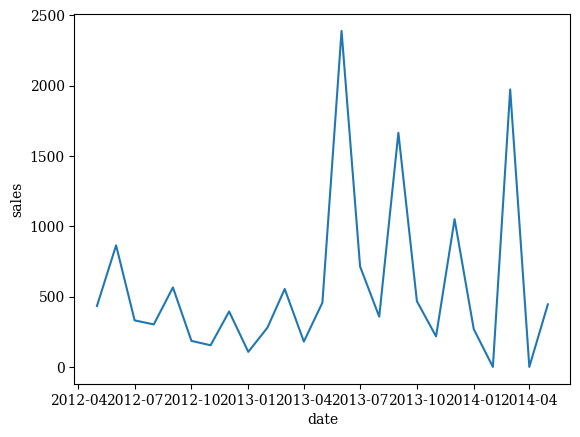

In [42]:
sns.lineplot(x=dfg_france.date, y=dfg_france.sales)

In [43]:
result_france = seasonal_decompose(dfg_france['sales'], model = 'adictive', period = 12)

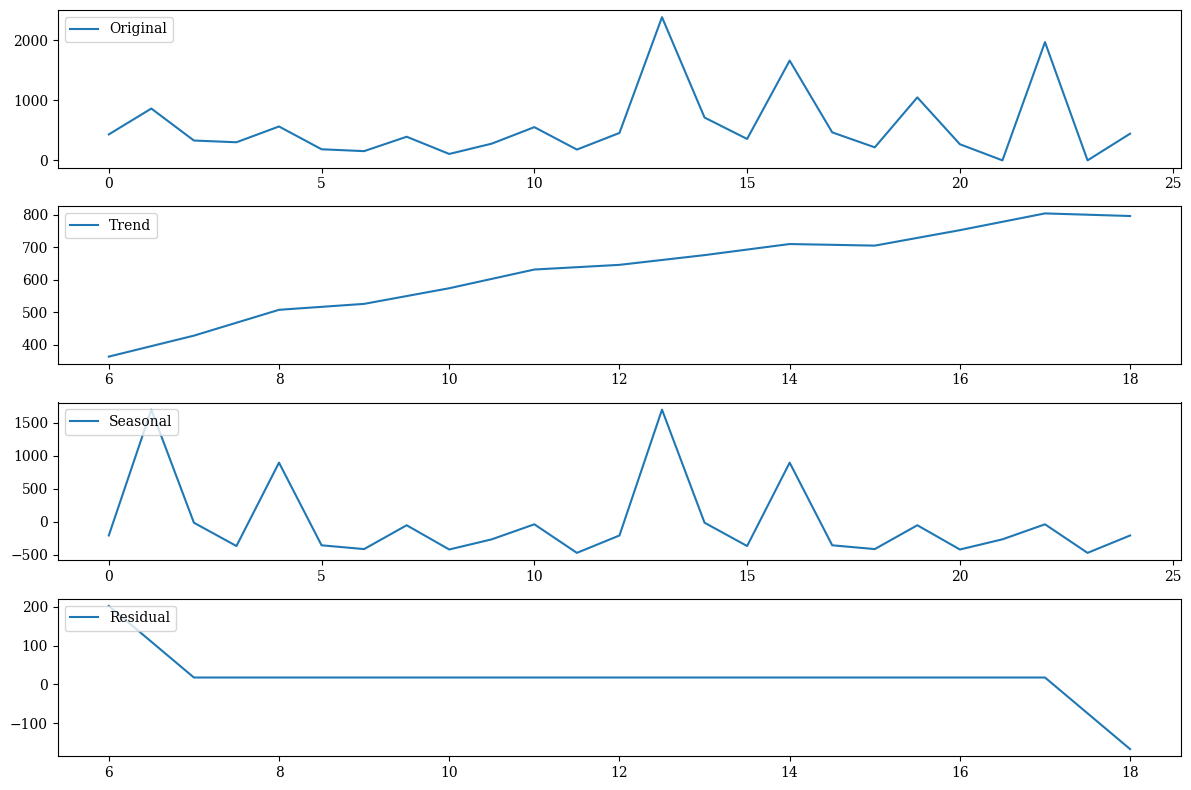

In [44]:
seasonal_decomposition_plots(data=dfg_france, seasonal_decomposition=result_france)

When we look at the plot of monthly sales in France, it is very different from the whole sales. With the begining beign smaller in magnitude and at the end sales start to rise. Another comportament to point is how the seasonality changed, having more peaks and lows.

## 4.3 Sales per Product

Now let's choose a category of products to study.
there is a question regarding prediction on Gloves, so I'll agregate sales by all Gloves products.

In [475]:
products = ['Full-Finger Gloves, S','Full-Finger Gloves, M','Full-Finger Gloves, L'
            ,'Half-Finger Gloves, L','Half-Finger Gloves, M','Half-Finger Gloves, S']

In [481]:
dfg_gloves = preparing_agregation(df=data, filter = products, metric='product')

<Axes: xlabel='date', ylabel='sales'>

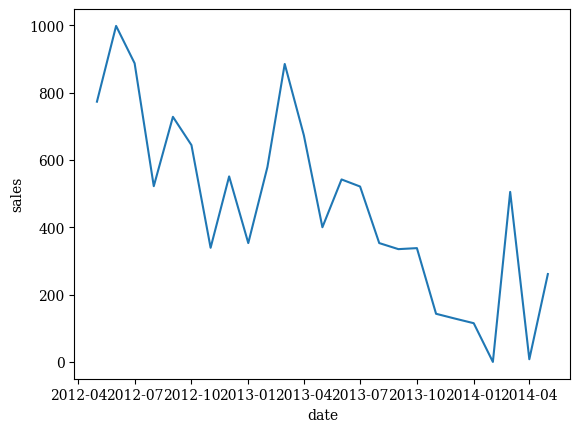

In [47]:
sns.lineplot(x=dfg_gloves.date, y=dfg_gloves.sales)

In [48]:
result_gloves = seasonal_decompose(dfg_gloves['sales'], model = 'adictive', period = 12)

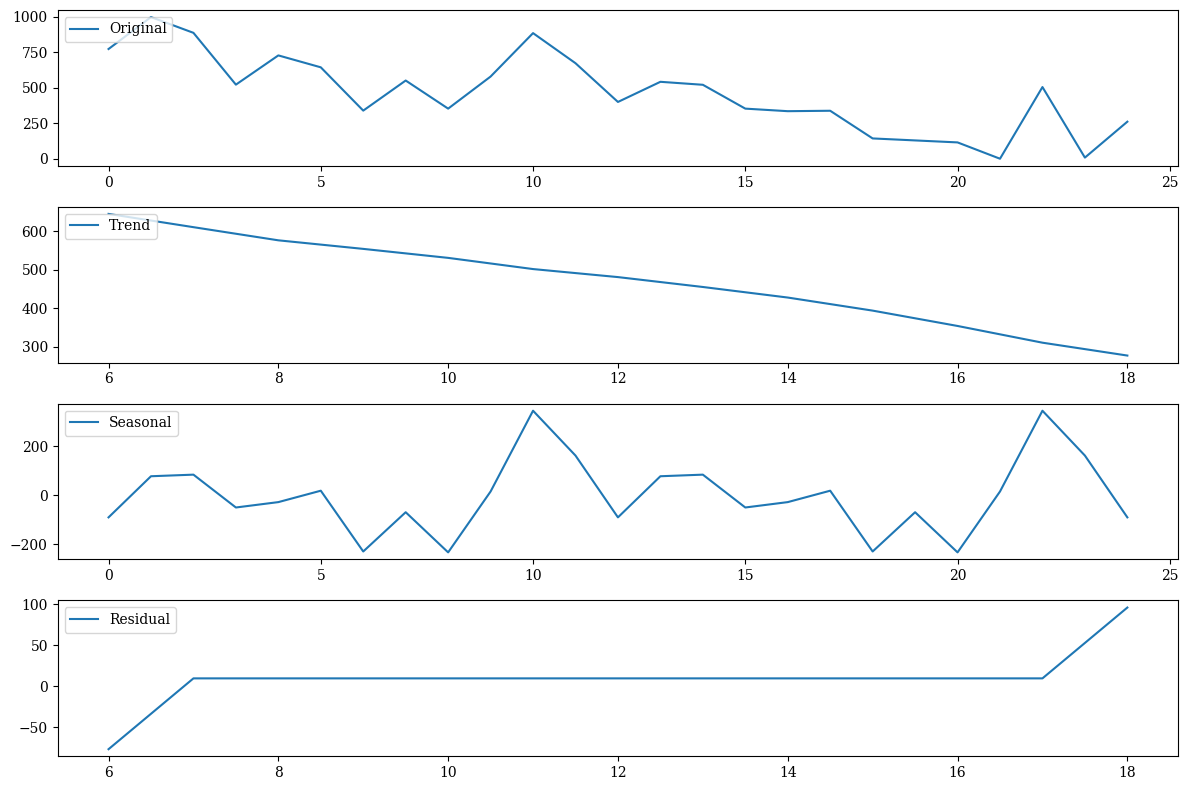

In [49]:
seasonal_decomposition_plots(data=dfg_gloves, seasonal_decomposition=result_gloves)

When agregating sales by product that are Gloves, we see that the trend is complete opposite from the previous two analysis. It is going down.

And looking at seasonality we can see that it begins lower and goes up before starting the cycle again.

Now let's choose only one of those products to see if there is many zeros in the series. This can affect the type of model used later on.

In [ ]:
dfg_gloves = preparing_agregation(df=data, filter = products[0], metric='product')

# 5. Hierarchical Time Series

Now we can apply Hierarchical Time Series to help us answer the business questions stated at the beginning of this notebook.


In [15]:
hierarquies = [
    ['country']
    , ['country', 'store']
    , ['country', 'store', 'product']
]

In [16]:
hts = data.rename(columns = {'date':'ds','sales':'y'})

In [17]:
Y_df, S_df, tags = aggregate(hts,hierarquies)

In [18]:
Y_df.index.value_counts()

,count
unique_id,
Canada,32
United States,32
France,23
United Kingdom,23
Germany,13
...,...
"United States/Golf and Cycle Store/ML Mountain Frame - Black, 40",1
"Canada/One Bike Company/ML Mountain Frame - Black, 48",1
"Canada/One Bike Company/ML Mountain Frame-W - Silver, 40",1


Looking at the table above, the expected result would be to have the same amount of rows for each hierarchy group. This way have one row of sales for each month in the series, even if it is null.

So I will use a function to fill this missing data.

In [19]:
Y_df = fill_gaps(df=Y_df.reset_index(), freq='M', start='global', end= 'global')

In [20]:
Y_df = Y_df.set_index('unique_id')

In [21]:
Y_df = Y_df.fillna(0)

In [22]:
Y_df.index.value_counts()

,count
unique_id,
Australia,37
"United States/Juvenile Sports Equipment/Women's Tights, L",37
"United States/Juvenile Sports Equipment/Sport-100 Helmet, Blue",37
"United States/Juvenile Sports Equipment/Sport-100 Helmet, Black",37
"United States/Juvenile Sports Equipment/Mountain-300 Black, 48",37
...,...
United Kingdom/Downhill Bicycle Specialists/HL Fork,37
"United Kingdom/Downhill Bicycle Specialists/Full-Finger Gloves, S",37
"United Kingdom/Downhill Bicycle Specialists/Full-Finger Gloves, M",37


In [23]:
Y_df.shape

(782217, 2)

## 5.1 Split Data

In order to choose train our model we will have to split our data into two. One will be our train dataset, used to train the model. And the other will be our test dataset. And it will be used to evaluate how our model performed.

For time series analysis, the test dataset should have the same period as we are trying to predict. In this case we want to predict the next 3 months of sale, so this should be the size of how test dataset.

In [324]:
Y_df = Y_df.reset_index()
Y_test_df = Y_df.groupby('unique_id').tail(3)
Y_train_df = Y_df.drop(Y_test_df.index)

In [325]:
Y_train_df.tail()

,unique_id,ds,y
782209,"United States/eCommerce Bikes/Women's Tights, S",2013-10-01,0
782210,"United States/eCommerce Bikes/Women's Tights, S",2013-11-01,0
782211,"United States/eCommerce Bikes/Women's Tights, S",2013-12-01,0
782212,"United States/eCommerce Bikes/Women's Tights, S",2014-01-01,0
782213,"United States/eCommerce Bikes/Women's Tights, S",2014-02-01,0


## 5.2 Model Training



The models chosen to carry out this analysis were: ADIDA, AutoETS and Seasonal Naive.

ADIDA: It is a model that takes into account intermittent series, that is, series that have many null values. As we saw previously, there are series that have many nulls. Mainly in the most granular part of the hierarchy, which is precisely where we want to predict better results. Therefore, we will use this model to take into account this peculiarity of the data.

AutoETS: Because it is an automatic model and is simpler to implement, since for AutoETS the best parameters are selected by the model itself.

Seasonal Naive: is a simple method used as a benchmark. It chooses the predicted value based on the seasonality of the data and the previous period. Therefore, we can have a comparison between model approaches.

PS: Despite being well known, the AutoARIMA model was not chosen, because the dataset had many null values in certain periods, which resulted in divisions by zero. Therefore, a model that considers intermittency was used as an alternative.

In [326]:
sf = StatsForecast(
    df=Y_train_df,
    models=[ADIDA(),AutoETS(season_length=12),SeasonalNaive(season_length=12)],
    freq='MS'
)

In [327]:
Y_hat_df = sf.forecast(h=3, fitted= True)

In [417]:
Y_hat_df.head()

,ds,ADIDA,AutoETS,SeasonalNaive
unique_id,,,,
Australia,2014-03-01,203.633255,269.45816,0.0
Australia,2014-04-01,203.633255,269.45816,0.0
Australia,2014-05-01,203.633255,269.45816,124.0
Australia/Bike Part Wholesalers,2014-03-01,3.272727,23.19383,0.0
Australia/Bike Part Wholesalers,2014-04-01,3.272727,23.19383,0.0


### 5.2.1 Training a Comparison Models

Since the ADW team currently uses moving averages to predict their sales. I'll train a WindowAverage model, to compare to the new models we are testing.

This is another kind of model to the Stats Forecast library and that is why we could not forecast it along with the others.

In [329]:
sf_compare = StatsForecast(
    df=Y_train_df,
    models=[WindowAverage(window_size=3)],
    freq='MS'
)

In [330]:
Y_hat_compare = sf_compare.forecast(h=3)

Now that we have the forecast for the comparison model. I'll merge the results for all models together and use this as a benchmark for evaluation.

In [331]:
Y_hat_all = pd.concat([Y_hat_df, Y_hat_compare.drop(columns='ds')], axis=1)
Y_hat_all

,ds,ADIDA,AutoETS,SeasonalNaive,WindowAverage
unique_id,,,,,
Australia,2014-03-01,203.633255,269.458160,0.0,206.333328
Australia,2014-04-01,203.633255,269.458160,0.0,206.333328
Australia,2014-05-01,203.633255,269.458160,124.0,206.333328
Australia/Bike Part Wholesalers,2014-03-01,3.272727,23.193830,0.0,24.666666
Australia/Bike Part Wholesalers,2014-04-01,3.272727,23.193830,0.0,24.666666
...,...,...,...,...,...
"United States/eCommerce Bikes/Women's Tights, M",2014-04-01,0.072000,0.207210,0.0,0.000000
"United States/eCommerce Bikes/Women's Tights, M",2014-05-01,0.072000,0.207210,0.0,0.000000
"United States/eCommerce Bikes/Women's Tights, S",2014-03-01,0.649250,0.578251,7.0,0.000000


## 5.3 Model Evaluation

The metrics chosen to evaluate the models were: WMAPE and RMSE.

The RMSE metric provides a value in the same unit of measurement as the predicted value, being easy to understand and good for comparing series.

In addition, the WMAPE metric will be used instead of the more common MAPE metric. This is because MAPE provides infinite value when values are zero, and penalizes very low values. As our data has series with many null values, we preferred to use WMAPE, which does not have this problem.

In [334]:
evaluator = HierarchicalEvaluation(evaluators=[rmse,wape])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_hat_all, Y_test_df=Y_test_df.set_index('unique_id'),
        tags=tags, benchmark='SeasonalNaive')
evaluation

ADIDA   AutoETS SeasonalNaive  \
level                 metric                                          
Overall               rmse-scaled  1.184465   1.36725           1.0   
                      wape-scaled  0.845647  0.917576           1.0   
country               rmse-scaled  1.247976  1.451667           1.0   
                      wape-scaled  1.235601  1.353549           1.0   
country/store         rmse-scaled  0.686887  0.660765           1.0   
                      wape-scaled  0.807369  0.851911           1.0   
country/store/product rmse-scaled  0.711325  0.673575           1.0   
                      wape-scaled  0.734693  0.812961           1.0   

                                  WindowAverage  
level                 metric                     
Overall               rmse-scaled      1.260267  
                      wape-scaled      0.812223  
country               rmse-scaled      1.331566  
                      wape-scaled      1.287039  
country/store         rmse-scaled      0.689996  
                      wape-scaled      0.766559  
country/store/product rmse-scaled      0.691893  
                      wape-scaled      0.676321

In [335]:
evaluation.idxmin(axis=1)


level                  metric     
Overall                rmse-scaled    SeasonalNaive
                       wape-scaled    WindowAverage
country                rmse-scaled    SeasonalNaive
                       wape-scaled    SeasonalNaive
country/store          rmse-scaled          AutoETS
                       wape-scaled    WindowAverage
country/store/product  rmse-scaled          AutoETS
                       wape-scaled    WindowAverage
dtype: object

As we can see, if we used only WAPE as a metric of evaluation, the WindowAverage method would perform better in thre out of four models.

While if we used only RMSE than other models would out perform over Window Averages. Since we are choosing to follow RMSE metric to choose better performance than we could say that it is better to use either SeasonalNaive or AutoETS over Window Average.

## 5.4 Model Reconciliation

Since our goal is to evaluate and try new ways to predict sales for ADW, the BottomUp reconciliation method will be used.

This method will use the lowest granularity level (country/store/product) to predict quantity sold and then sum value to build higher granularities. It will be more specific about product demand, and

The objective of the study is to evaluate alternatives for forecasting demand for ADW products. Therefore, it makes more sense to apply the BottomUp reconciliation method, as it will make a more accurate forecast at lower hierarchy levels.

Furthermore, for models with many zero values, the TopDown method will not perform very well. And since we have few hierarchies, the MiddleOut method would not make sense. In addition to being more computationally demanding.

In [336]:
reconcilers = [
    BottomUp()
]

In [337]:
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

In [338]:
Y_fitted_df = sf.forecast_fitted_values()

In [339]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)

In [340]:
Y_rec_df.head(10)


,ds,ADIDA,AutoETS,SeasonalNaive,ADIDA/BottomUp,AutoETS/BottomUp,SeasonalNaive/BottomUp
unique_id,,,,,,,
Australia,2014-03-01,203.633255,269.458160,0.0,46.785011,200.120255,0.0
Australia,2014-04-01,203.633255,269.458160,0.0,46.785011,203.258224,0.0
Australia,2014-05-01,203.633255,269.458160,124.0,46.785011,206.396164,124.0
Canada,2014-03-01,932.372864,530.723328,1546.0,803.006470,1282.810181,1546.0
Canada,2014-04-01,932.372864,530.723328,1389.0,803.006470,1299.903809,1389.0
Canada,2014-05-01,932.372864,530.723328,1711.0,803.006470,1296.214478,1711.0
France,2014-03-01,535.477539,522.364441,554.0,246.786804,480.732758,554.0
France,2014-04-01,535.477539,522.364441,180.0,246.786804,481.546478,180.0
France,2014-05-01,535.477539,522.364441,457.0,246.786804,482.360199,457.0


In [341]:
evaluator = HierarchicalEvaluation(evaluators=[rmse,wape])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df.set_index('unique_id'),
        tags=tags, benchmark='SeasonalNaive')

evaluation

ADIDA   AutoETS SeasonalNaive  \
level                 metric                                          
Overall               rmse-scaled  1.184465   1.36725           1.0   
                      wape-scaled  0.845647  0.917576           1.0   
country               rmse-scaled  1.247976  1.451667           1.0   
                      wape-scaled  1.235601  1.353549           1.0   
country/store         rmse-scaled  0.686887  0.660765           1.0   
                      wape-scaled  0.807369  0.851911           1.0   
country/store/product rmse-scaled  0.711325  0.673575           1.0   
                      wape-scaled  0.734693  0.812961           1.0   

                                  ADIDA/BottomUp AutoETS/BottomUp  \
level                 metric                                        
Overall               rmse-scaled       1.247474         1.087973   
                      wape-scaled       0.849175         0.886539   
country               rmse-scaled       1.316007         1.143797   
                      wape-scaled       1.310387         1.153542   
country/store         rmse-scaled       0.706144         0.658067   
                      wape-scaled       0.784193         0.857514   
country/store/product rmse-scaled       0.711325         0.673575   
                      wape-scaled       0.734693         0.812961   

                                  SeasonalNaive/BottomUp  
level                 metric                              
Overall               rmse-scaled                    1.0  
                      wape-scaled                    1.0  
country               rmse-scaled                    1.0  
                      wape-scaled                    1.0  
country/store         rmse-scaled                    1.0  
                      wape-scaled                    1.0  
country/store/product rmse-scaled                    1.0  
                      wape-scaled                    1.0

In [342]:
evaluation.drop(columns = ['ADIDA','AutoETS','SeasonalNaive']).idxmin(axis=1)

level                  metric     
Overall                rmse-scaled    SeasonalNaive/BottomUp
                       wape-scaled            ADIDA/BottomUp
country                rmse-scaled    SeasonalNaive/BottomUp
                       wape-scaled    SeasonalNaive/BottomUp
country/store          rmse-scaled          AutoETS/BottomUp
                       wape-scaled            ADIDA/BottomUp
country/store/product  rmse-scaled          AutoETS/BottomUp
                       wape-scaled            ADIDA/BottomUp
dtype: object

## 5.5 Visualizing Forecasts

Here we are going to use the forecasted reconciled models to plot charts and see differences in models for different hierarchies.

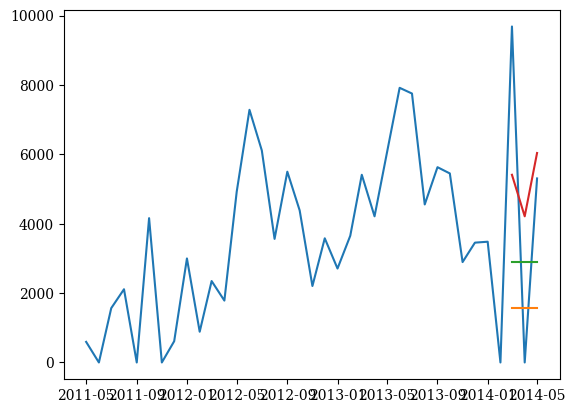

In [343]:
plt.plot(Y_df[Y_df.unique_id == (tags.get('country').tolist()[-1])]['ds'],Y_df[Y_df.unique_id == (tags.get('country').tolist()[-1])]['y'])
plt.plot(Y_hat_df[Y_hat_df.index == (tags.get('country').tolist()[-1])]['ds'],Y_hat_df[Y_hat_df.index== (tags.get('country').tolist()[-1])]['AutoETS'])
plt.plot(Y_hat_df[Y_hat_df.index == (tags.get('country').tolist()[-1])]['ds'],Y_hat_df[Y_hat_df.index== (tags.get('country').tolist()[-1])]['ADIDA'])
plt.plot(Y_hat_df[Y_hat_df.index == (tags.get('country').tolist()[-1])]['ds'],Y_hat_df[Y_hat_df.index== (tags.get('country').tolist()[-1])]['SeasonalNaive'] )

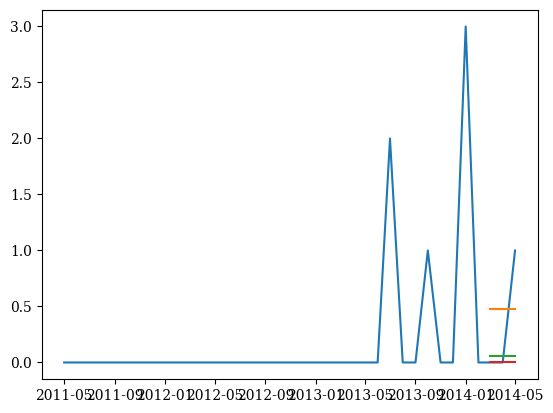

In [344]:
plt.plot(Y_df[Y_df.unique_id == (tags.get('country/store/product').tolist()[5])]['ds'],Y_df[Y_df.unique_id == (tags.get('country/store/product').tolist()[5])]['y'])
plt.plot(Y_hat_df[Y_hat_df.index == (tags.get('country/store/product').tolist()[5])]['ds'],Y_hat_df[Y_hat_df.index== (tags.get('country/store/product').tolist()[5])]['AutoETS'])
plt.plot(Y_hat_df[Y_hat_df.index == (tags.get('country/store/product').tolist()[5])]['ds'],Y_hat_df[Y_hat_df.index== (tags.get('country/store/product').tolist()[5])]['ADIDA'])
plt.plot(Y_hat_df[Y_hat_df.index == (tags.get('country/store/product').tolist()[5])]['ds'],Y_hat_df[Y_hat_df.index== (tags.get('country/store/product').tolist()[5])]['SeasonalNaive'] )

This shows us a couple series and how all models applied are different from each other.

# 6. Model Application

Now that we have modeled our data, evaluated it using metrics and reconciliated it. We are ready to apply it and answer our initial business questions.

First thing to do is apply the model to our whole data frame to predict the next 3 months (June, July and August).

As seen before the best reconciled model for the lower granularity level (country/store/product) was AutoETS using the lower RMSE error. That is why we will only use this model and method here.

In [345]:
sf_predict = StatsForecast(
    df=Y_df,
    models=[AutoETS(season_length=12)],
    freq='MS'
)

In [346]:
Y_hat = sf_predict.forecast(h=3, fitted=True)

In [347]:
hrec_predict = HierarchicalReconciliation(reconcilers=reconcilers)

In [348]:
Y_fitted = sf_predict.forecast_fitted_values()

In [349]:
Y_rec = hrec_predict.reconcile(Y_hat_df=Y_hat, Y_df=Y_fitted, S=S_df, tags=tags)

In [350]:
Y_rec = Y_rec.rename(columns = {'AutoETS/BottomUp_intervals_method-None_P-[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n ...\n [0. 0. 0. ... 1. 0. 0.]\n [0. 0. 0. ... 0. 1. 0.]\n [0. 0. 0. ... 0. 0. 1.]]_W-None_sampler-None_fitted-True' :'AutoETS BottomUp'})

### Predicting with Moving Average

I'll also use WindowAverage model to predict the next three month so that we can compare it to the other models performance and see how results could be potencially different.

In [365]:
sf_compare = StatsForecast(
    df=Y_df,
    models=[WindowAverage(window_size=3)],
    freq='MS'
)

In [366]:
Y_hat_compare = sf_compare.forecast(h=3)

In [367]:
hrec_compare = HierarchicalReconciliation(reconcilers=reconcilers)

In [368]:
Y_rec_compare = hrec_compare.reconcile(Y_hat_df=Y_hat_compare, S=S_df, tags=tags)

In [369]:
Y_rec_compare = Y_rec_compare.rename(columns = {'WindowAverage/BottomUp_intervals_method-None_P-[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n ...\n [0. 0. 0. ... 1. 0. 0.]\n [0. 0. 0. ... 0. 1. 0.]\n [0. 0. 0. ... 0. 0. 1.]]_W-None_sampler-None_fitted-True' :'WindowAverage BottomUp'}).drop(columns = 'ds')

In [370]:
Y_rec_compare

,WindowAverage,WindowAverage BottomUp
unique_id,,
Australia,405.666656,405.666565
Australia,405.666656,405.666565
Australia,405.666656,405.666565
Canada,1630.666626,1630.666504
Canada,1630.666626,1630.666504
...,...,...
"United States/eCommerce Bikes/Women's Tights, M",0.000000,0.000000
"United States/eCommerce Bikes/Women's Tights, M",0.000000,0.000000
"United States/eCommerce Bikes/Women's Tights, S",0.000000,0.000000


In [371]:
Y_total = pd.concat([Y_rec, Y_rec_compare], axis=1)

In [372]:
Y_total

,ds,AutoETS,AutoETS BottomUp,WindowAverage,WindowAverage BottomUp
unique_id,,,,,
Australia,2014-06-01,351.684937,285.770233,405.666656,405.666565
Australia,2014-07-01,351.684937,293.831665,405.666656,405.666565
Australia,2014-08-01,351.684937,301.893250,405.666656,405.666565
Canada,2014-06-01,1344.009155,1469.625977,1630.666626,1630.666504
Canada,2014-07-01,1344.009155,1490.665649,1630.666626,1630.666504
...,...,...,...,...,...
"United States/eCommerce Bikes/Women's Tights, M",2014-07-01,0.189456,0.189456,0.000000,0.000000
"United States/eCommerce Bikes/Women's Tights, M",2014-08-01,0.189456,0.189456,0.000000,0.000000
"United States/eCommerce Bikes/Women's Tights, S",2014-06-01,0.412703,0.412703,0.000000,0.000000


## 6.1 Distribution Center Comparison

Now that we predicted the next months of sale for each time serie. Let's answer our business questions.

First one is about distribution centers. We know that there is one center for each state in the US as well as one per country, for every other country in the database.

We want to compare demandas for each group, US versus all other countries. To know which group will have a greater demand. This way ADW can understand where to prioritize production or staff for distribution center, for example.

This way, we are goin to calculate the next 3 month demand for the US and in anthoer table the forecast for the other countries.

In [373]:
# Other Countries 3-month demand
(Y_total.loc[tags.get('country').tolist()[:-1]]).groupby(['ds']).sum()

,AutoETS,AutoETS BottomUp,WindowAverage,WindowAverage BottomUp
ds,,,,
2014-06-01,3387.321289,3303.821289,4187.333008,4187.33252
2014-07-01,3387.321289,3359.472168,4187.333008,4187.33252
2014-08-01,3387.321289,3414.891357,4187.333008,4187.33252


In [374]:
# United States 3-month demand
Y_total.loc[tags.get('country').tolist()[-1]]

,ds,AutoETS,AutoETS BottomUp,WindowAverage,WindowAverage BottomUp
unique_id,,,,,
United States,2014-06-01,4060.356934,4560.897461,4996.666504,4996.666016
United States,2014-07-01,4060.356934,4605.326660,4996.666504,4996.666016
United States,2014-08-01,4060.356934,4655.489258,4996.666504,4996.666016


Using the result for the reconciled model. We can say that for  US demand is greater than for other countries for each month separetly as well as for the whole three month period.

Considering the whole period the US had close to 900K more units than for other countries. A difference of 27% between them.

This shows how big is the market for ADW in the US.

This would also be true if we using the moving average model. Although the difference between the two groups here would be of 16%

## 6.2 Gloves Demand Forecast

The business question we want to answer here is how many zippers will be needed to make gloves for the next 3 months.

So the idea here is to get all series in the last hierarchy level (country/store/product) that have gloves as a product.

When looking in our data base, there is two type of gloves that comes in three sizes. Their names are:

- Full-Finger Gloves, S
- Full-Finger Gloves, M
- Full-Finger Gloves, L
- Half-Finger Gloves, L
- Half-Finger Gloves, M
- Half-Finger Gloves, S

We will look for this products and calculate the demand of each month using the predicted values done in item 6.

In [375]:
Y_rec.head()

,ds,AutoETS,AutoETS BottomUp
unique_id,,,
Australia,2014-06-01,351.684937,285.770233
Australia,2014-07-01,351.684937,293.831665
Australia,2014-08-01,351.684937,301.893250
Canada,2014-06-01,1344.009155,1469.625977
Canada,2014-07-01,1344.009155,1490.665649


In [377]:
series = tags.get('country/store/product').tolist()
glove_products = [item for item in series if re.findall(r'\sGloves,\s', item)]

In [379]:
len(glove_products)

738

In [381]:
Y_total.loc[glove_products].groupby('ds').sum()

,AutoETS,AutoETS BottomUp,WindowAverage,WindowAverage BottomUp
ds,,,,
2014-06-01,327.447601,327.447601,258.0,258.0
2014-07-01,329.028748,329.028748,258.0,258.0
2014-08-01,330.609924,330.609924,258.0,258.0


There are 738 series that sells Gloves, this can be from any store in any country.

Using the reconciled model prediction the total number of gloves expected to be sold in the next three months is: 987.

This mean that the supplier should order 1,974 zippers to be able to make all of theses gloves.

Using the moving average as a comparison we would have predicted 426 zippers less than the predicted with AutoETS.

## 6.3 Linear Regression Comparison

Now we are ready to answer the last business question proposed at the begining of our analysis, which is to study how a regression model would perform against the models applied earlier for a time series.

Since we don't have a library that does all series automatically, we used SKForecast in each series. But defined a function (on item 1.6) to make predictions for all series at once.

The idea was to run all series at once, but since there are over 200,000 different series I chose to run parts of it to go faster. That is why I also defined a "chunks" function to split data into 5 pieces.

In [424]:
Y_df = Y_df.set_index('unique_id')

In [425]:
#Defining chuks to run model in parts.
products = Y_df[Y_df.index.isin(tags.get('country/store/product').tolist())]
products_list = chunks(products, 151700)

In [ ]:
Y_reg = pd.DataFrame()

In [450]:
#Remender to run this cell multiple times, changing index from 0 until 5
Y = liner_reg_prediction(products_list[5], lag=4, step=3)
Y_reg = pd.concat([Y_reg,Y])

In [452]:
Y_reg

,ds,pred
unique_id,,
Australia/Bike Part Wholesalers/AWC Logo Cap,2014-03-01,0.105685
Australia/Bike Part Wholesalers/AWC Logo Cap,2014-04-01,3.395626
Australia/Bike Part Wholesalers/AWC Logo Cap,2014-05-01,0.097273
Australia/Bike Part Wholesalers/Bike Wash - Dissolver,2014-03-01,0.127878
Australia/Bike Part Wholesalers/Bike Wash - Dissolver,2014-04-01,4.276704
...,...,...
"United States/eCommerce Bikes/Women's Tights, M",2014-04-01,0.187978
"United States/eCommerce Bikes/Women's Tights, M",2014-05-01,0.175440
"United States/eCommerce Bikes/Women's Tights, S",2014-03-01,0.412784


In [462]:
Y_rec_products = Y_rec.loc[tags.get('country/store/product').tolist()]
Y_rec_products['LinearRegression'] = Y_reg['pred']

In [463]:
Y_rec_products

,ds,AutoETS,AutoETS BottomUp,LinearRegression
unique_id,,,,
Australia/Bike Part Wholesalers/AWC Logo Cap,2014-06-01,1.130518,1.130518,0.105685
Australia/Bike Part Wholesalers/AWC Logo Cap,2014-07-01,1.130518,1.130518,3.395626
Australia/Bike Part Wholesalers/AWC Logo Cap,2014-08-01,1.130518,1.130518,0.097273
Australia/Bike Part Wholesalers/Bike Wash - Dissolver,2014-06-01,2.226584,2.226584,0.127878
Australia/Bike Part Wholesalers/Bike Wash - Dissolver,2014-07-01,2.305399,2.305399,4.276704
...,...,...,...,...
"United States/eCommerce Bikes/Women's Tights, M",2014-07-01,0.189456,0.189456,0.187978
"United States/eCommerce Bikes/Women's Tights, M",2014-08-01,0.189456,0.189456,0.175440
"United States/eCommerce Bikes/Women's Tights, S",2014-06-01,0.412703,0.412703,0.412784


In [469]:
#Defining new tags to evaluate only one hierarchical level, which is the lowest.
new_tags = {'country/store/product': tags.get('country/store/product')}

In [471]:
evaluator = HierarchicalEvaluation(evaluators=[rmse,wape])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_products, Y_test_df=Y_test_df.set_index('unique_id'),
        tags=new_tags)
evaluation

AutoETS AutoETS BottomUp LinearRegression
level                 metric                                            
Overall               rmse     1.47457          1.47457         1.726759
                      wape    1.448956         1.448956         1.452154
country/store/product rmse     1.47457          1.47457         1.726759
                      wape    1.448956         1.448956         1.452154

After using the regression model for the lowest granularity. The evaluation function was used to get the metrics and compare both regression and time series methods.

As we can see above, for WMAPE valueas for regression are very close to time series. Only 0.01 difference.
As for RMSE, values differ a little bit more. But even so, the difference is lower than 0.3.

As for computacional time, both models took about the same time to be done.

# 7. Useful Links

Here are some of the links I used to help me develop and study to do this model.

- [StatsForecast Documentation](https://nixtlaverse.nixtla.io/statsforecast/index.html)
- [HierarchicalForecast Documentation](https://nixtlaverse.nixtla.io/hierarchicalforecast/index.html)
- [ADIDA Model](https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#adida)
- [Seasonal Naive Model](https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#seasonalnaive)
- [AutoETS Model](https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#autoets)
- [Window Average Model](https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#windowaverage)
- [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
- [Multi-Step Time Series Forecasting In Python](https://forecastegy.com/posts/multi-step-time-series-forecasting-in-python/#recursive-or-autoregressive-method-in-pure-python)
- [SKForecast Documentation](https://skforecast.org/0.13.0/user_guides/autoregresive-forecaster.html)